In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import os

In [2]:
rel_data_dir_full = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'
plot_dir = './plots/'
outdir = './'

In [3]:
'''
Wave 8 Release 8.0.0
DOI: 10.6103/SHARE.w8.800
2022-02-10 00:53:53
'''
all_files = glob(f"{rel_data_dir_full}*.dta")

'''
easySHARE Release 8.0.0
DOI: 10.6103/SHARE.easy.800
2022-02-10 01:00:22
'''
easy_files = glob(f"{rel_data_dir_easy}*.dta")

'''
Wave 8 Accelerometer Epochs Release 8.0.0
DOI: 10.6103/SHARE.w8.800
2022-02-10 01:04:04
'''
acc_files = glob(f"{rel_data_dir_full}dta/**/*.dta", recursive=True)

Loading the datasets from SHARE 

In [4]:
df_easy = pd.read_stata(easy_files[0])
df_ph = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_ph.dta'))
df_acc_hr = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_accelerometer_hour.dta'))
df_acc = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_accelerometer_total.dta'))
df_acc_imp = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_imputations.dta'))
df_acc_hr_clean = df_acc_hr.iloc[:,0:15]

Data prep

In [5]:
df_acc_hr_clean.loc[:, 'OxCGRT_stay_at_home'] = df_acc_hr_clean['OxCGRT_stay_at_home'].replace({
    'No measures': 'No restrictions',
    "Require not leaving house with exceptions for daily exercise, grocery shopping, and 'essential' trips": 'Essential only',
    "Recommend not leaving house": 'Stay at home',
})

In [6]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [7]:
df = df_acc_hr_clean.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df_ph[get_common_columns(df_ph, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_acc[get_common_columns(df_acc, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_easy[get_common_columns(df_easy, df)], right_on=['mergeid'], how='left')

df = df[df['wave'] == 8]

In [8]:
def map_selected_num(df, columns: list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -2,
            1: 1,
            0: 0,
            -1: -1,
            -2: -2,
        })
    return df

In [9]:
#                        Hypertension, Diabetis, Osteoarthritis, pain hips, pain knee
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])

Defining Osteoarthritis 

ph006d20: Osteoarthritis/other rheumatism: ever diagnosed/currently having

ph087d2: Pain location: hips or
ph087d3: Pain location: knees


d1: Hypertension

d2: Diabetes

d3: OA (in hip/knee)

d4: Hypertension + Diabetes

d5: Hypertension + OA

d6: Diabetes + OA

d7: Hypertension + Diabetes + OA  

In [13]:
df['Hypertension'] = pd.to_numeric(df['ph006d2'])
df['Diabetes'] = pd.to_numeric(df['ph006d5'])
df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))

In [14]:
df['d1'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d3'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d4'] = np.where((df['d1'] == 1) & (df['d2'] == 1) & (df['d3'] == 0), int(1), int(0))
df['d5'] = np.where((df['d1'] == 1) & (df['d3'] == 1) & (df['d2'] == 0), int(1), int(0))
df['d6'] = np.where((df['d3'] == 1) & (df['d2'] == 1) & (df['d1'] == 0), int(1), int(0))
df['d7'] = np.where((df['d1'] == 1) & (df['d2'] == 1) & (df['d3'] == 1), int(1), int(0))
df['control'] = np.where((df['d1'] == 0) & (df['d2'] == 0) & (df['d3'] == 0), int(1), int(0))

In [15]:
df['disease'] = 'c'
df.loc[(df['d1'] == 1) & (df['d2'] == 0) & (df['d3'] == 0), 'disease'] = 'd1'
df.loc[(df['d1'] == 0) & (df['d2'] == 1) & (df['d3'] == 0), 'disease'] = 'd2'
df.loc[(df['d1'] == 0) & (df['d2'] == 0) & (df['d3'] == 1), 'disease'] = 'd3'
df.loc[(df['d1'] == 1) & (df['d2'] == 1) & (df['d3'] == 0), 'disease'] = 'd4'
df.loc[(df['d1'] == 1) & (df['d2'] == 0) & (df['d3'] == 1), 'disease'] = 'd5'
df.loc[(df['d1'] == 0) & (df['d2'] == 1) & (df['d3'] == 1), 'disease'] = 'd6'
df.loc[(df['d1'] == 1) & (df['d2'] == 1) & (df['d3'] == 1), 'disease'] = 'd7'
#df.loc[(df['d1'] == 0) & (df['d2'] == 0) & (df['d3'] == 0), 'disease'] = 'c'
df['disease'].value_counts()

c     93216
d1    43728
d3     8616
d2     8040
Name: disease, dtype: int64

In [16]:
def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df

In [17]:
df = map_bmi_num(df)

In [18]:
df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)

In [19]:
df.drop(df[df.measurementday > 7].index, inplace=True)
df.loc[:, 'measurementday'] = df.replace({1: 'day1', 2: 'day2', 3: 'day3', 4: 'day4', 5: 'day5', 6: 'day6', 7: 'day7'})

In [20]:
groups = ['d1','d2','d3', 'd4','d5','d6','d7','control']

In [22]:
#fstring funktioniert nicht
#df_stat = df[['mergeid', 'female', 'age', 'bmi', 'GGIR_mean_ENMO_hour','GGIR_N_valid_hours','hour','measurementday','weekday','month','year','device_id', 'frequency', 'position', 'country',
#f'{groups}', 'disease']].copy()

df_stat = df[['mergeid', 'female', 'age', 'bmi', 'GGIR_mean_ENMO_hour','GGIR_N_valid_hours','hour','measurementday','weekday','month','year','device_id', 'frequency', 'position', 'country',
'd1','d2','d3', 'd4','d5','d6','d7','control', 'disease']].copy()
df_stat.rename(columns={'GGIR_mean_ENMO_hour': 'ENMO_hour'}, inplace=True)

In [39]:
df_stat.head(5)

,mergeid,female,age,bmi,ENMO_hour,GGIR_N_valid_hours,hour,measurementday,weekday,month,...,country,d1,d2,d3,d4,d5,d6,d7,control,disease
4,Bf-031257-01,0,67.0,21.155294,6.697222,0.0,12am-1am,day1,Tuesday,February,...,Belgium,0,0,0,0,0,0,0,1,c
9,Bf-031257-01,0,67.0,21.155294,10.741667,0.0,1am-2am,day1,Tuesday,February,...,Belgium,0,0,0,0,0,0,0,1,c
14,Bf-031257-01,0,67.0,21.155294,7.848472,0.5,2am-3am,day1,Tuesday,February,...,Belgium,0,0,0,0,0,0,0,1,c
19,Bf-031257-01,0,67.0,21.155294,0.244306,1.0,3am-4am,day1,Tuesday,February,...,Belgium,0,0,0,0,0,0,0,1,c
24,Bf-031257-01,0,67.0,21.155294,4.214167,1.0,4am-5am,day1,Tuesday,February,...,Belgium,0,0,0,0,0,0,0,1,c


Export to csv

In [23]:
# Export Dataframe to csv-file 
# df_stat.to_csv(r'merged_data.csv', index = False)

Summarize ENMO (mean, median, var) per respondent

In [24]:
def calc_ENMO_stats(df, enmo_col='ENMO_hour'):
    df = df.copy()
    mean = df.groupby('mergeid')[enmo_col].mean()
    median = df.groupby('mergeid')[enmo_col].median()
    var = df.groupby('mergeid')[enmo_col].var()
    mean.name = 'mean_ENMO'
    median.name = 'median_ENMO'
    var.name = 'var_ENMO'
    df = pd.merge(left=df, left_on='mergeid', right=mean, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=median, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=var, right_on='mergeid', how='left')
    return df

In [40]:
df_summarize = calc_ENMO_stats(df_stat)   
df_summarize = df_summarize.drop_duplicates(subset='mergeid', keep='first')
cols = ['ENMO_hour','GGIR_N_valid_hours','measurementday', 'hour', 'weekday']
df_summarize.drop(cols, inplace=True, axis=1)
df_summarize.head(5)

,mergeid,female,age,bmi,month,year,device_id,frequency,position,country,...,d3,d4,d5,d6,d7,control,disease,mean_ENMO,median_ENMO,var_ENMO
0,Bf-031257-01,0,67.000000,21.155294,February,2020,68652.0,50,Left,Belgium,...,0,0,0,0,0,1,c,12.164127,9.664236,119.962879
168,Bf-043946-02,1,57.299999,38.446751,February,2020,30920.0,50,Left,Belgium,...,0,0,0,0,0,0,d1,13.780020,8.492361,209.996045
336,Bf-073169-01,0,72.500000,25.209202,March,2020,68652.0,50,Right,Belgium,...,0,0,0,0,0,0,d1,16.090929,11.452292,537.459251
504,Bf-227520-04,0,56.099998,24.593210,March,2020,17212.0,50,Right,Belgium,...,0,0,0,0,0,0,d1,11.543128,11.326111,74.794850
552,Bf-286437-02,1,68.099998,30.778702,February,2020,54007.0,50,Right,Belgium,...,0,0,0,0,0,0,d1,38.811152,48.127569,367.199181


long to wide format

In [38]:
df_wide = df_stat.pivot_table(index='mergeid', columns='measurementday', values='ENMO_hour', aggfunc={'ENMO_hour': np.mean})
df_wide.dropna(inplace=True)
df_wide = pd.merge(df_wide, df_summarize, on='mergeid')
df_wide.head(5)

# alternative: https://www.statology.org/pandas-pivot-table-column-names/

,mergeid,day1,day2,day3,day4,day5,day6,day7,female,age,...,d3,d4,d5,d6,d7,control,disease,mean_ENMO,median_ENMO,var_ENMO
0,Bf-031257-01,7.842784,13.951765,14.691516,11.845631,15.103767,8.624473,13.088953,0,67.000000,...,0,0,0,0,0,1,c,12.164127,9.664236,119.962879
1,Bf-043946-02,14.734543,12.709763,11.554774,15.158368,8.666696,16.909890,16.726105,1,57.299999,...,0,0,0,0,0,0,d1,13.780020,8.492361,209.996045
2,Bf-073169-01,25.244525,10.036458,12.613015,11.006794,21.812749,15.087454,16.835509,0,72.500000,...,0,0,0,0,0,0,d1,16.090929,11.452292,537.459251
3,Bf-291361-02,42.403131,53.354855,53.780660,45.536817,44.093501,42.671858,40.565764,1,71.199997,...,0,0,0,0,0,1,c,46.058084,43.160000,1278.062974
4,Bf-294636-01,19.117378,15.019144,14.817222,15.841696,16.929803,16.612344,19.187679,1,55.900002,...,0,0,0,0,0,1,c,16.789324,15.660556,55.480780


Statistics - MANOVA

In [41]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [53]:
maov = MANOVA.from_formula('day1 + day2 + day3 + day4 + day5 + day6 + day7 ~ d1 + d2 + d3', data=df_wide)
print(maov.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.4526 7.0000 710.0000 122.6921 0.0000
         Pillai's trace 0.5474 7.0000 710.0000 122.6921 0.0000
 Hotelling-Lawley trace 1.2096 7.0000 710.0000 122.6921 0.0000
    Roy's greatest root 1.2096 7.0000 710.0000 122.6921 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
            d1           Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.9940 7.0000 710.0000  0.6142 0.7445
          Pillai's trace 0.0060 7.0000 710.0000  0.6142 0.7445
  Hotelling

Visualize the data

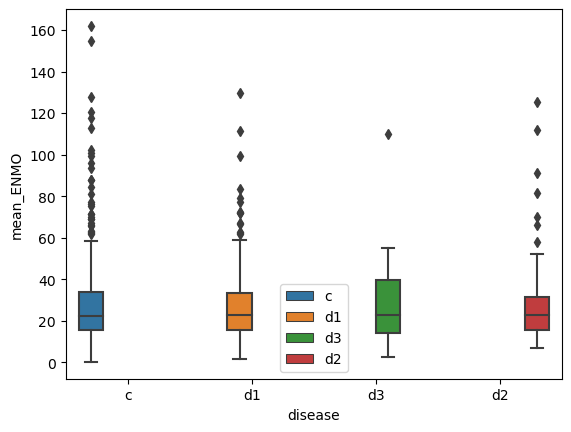

In [54]:
import seaborn as sns
sns.boxplot(data=df_summarize, x="disease", y="mean_ENMO", hue=df_summarize.disease.tolist())
plt.show()

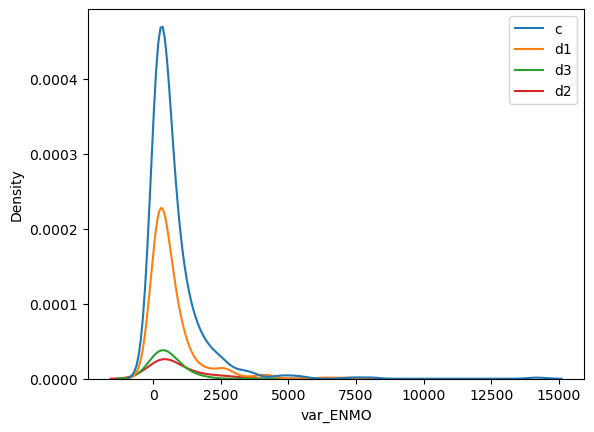

In [ ]:
sns.kdeplot(data=df_summarize, x="var_ENMO", hue=df_summarize.disease.tolist())
plt.show()

Multivariate Analysis of Variance (MANOVA) using statsmodels

to test significance of the group differences 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

X = df_stat[["d3", "control"]]
y = df_stat["ENMO_hour"]
y = y.astype(int)
post_hoc = lda().fit(X=X, y=y)

In [ ]:
# get Prior probabilities of groups:
post_hoc.priors_
np.array([0.25, 0.25, 0.25, 0.25])

# get group means
post_hoc.means_
np.array([[18.9  ,  0.784],
       [16.54 ,  0.608],
       [ 3.05 ,  0.272],
       [ 9.35 ,  0.474]])

# get Coefficients of linear discriminants
post_hoc.scalings_
np.array([[-0.43883736, -0.2751091 ],
       [-1.39491582,  9.32562799]])

# get Proportion of trace (variance explained by each of the selected components)
post_hoc.explained_variance_ratio_
np.array([0.98545382, 0.01454618])


array([0.98545382, 0.01454618])

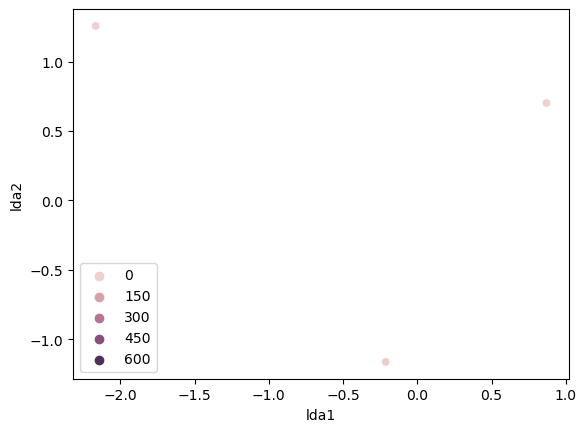

In [ ]:
# plot 
X_new = pd.DataFrame(lda().fit(X=X, y=y).transform(X), columns=["lda1", "lda2"])
X_new["ENMO_hour"] = df_stat["ENMO_hour"]
sns.scatterplot(data=X_new, x="lda1", y="lda2", hue=df_stat.ENMO_hour.tolist())
plt.show()

p < 0.001 => ENMO has a statistically significant association with dieseases 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X = df_stat.iloc[:,[16,17]]
y = df_stat.iloc[:,4].values
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Feature Scaling to Dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Implemented Linear Discriminant Analysis
lda = LDA(n_components = 2)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

# Train Logistic Regression with LDA
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predict Results of Regression with LDA
y_pred = classifier.predict(X_test)

KeyboardInterrupt: 

Visualize

In [ ]:
from matplotlib.colors import ListedColormap

X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min()-1, stop = X_set[:, 0].max() + 1, step = 0.01), 
                        np.arange(start = X_set[:, 1].min()-1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
    c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

reg = ols('d1~ENMO_hour', data=df_stat).fit()
aov_d1 = sm.stats.anova_lm(reg, typ=2)
print(aov_d1)

                 sum_sq        df           F        PR(>F)
ENMO_hour     54.989915       1.0  223.444292  1.740582e-50
Residual   37800.656335  153598.0         NaN           NaN


In [ ]:
reg = ols('d2~ENMO_hour', data=df_stat).fit()
aov_d1 = sm.stats.anova_lm(reg, typ=2)
print(aov_d1)

                 sum_sq        df          F    PR(>F)
ENMO_hour      1.366816       1.0  10.043718  0.001529
Residual   20902.633184  153598.0        NaN       NaN


In [ ]:
reg = ols('d3~ENMO_hour', data=df_stat).fit()
aov_d1 = sm.stats.anova_lm(reg, typ=2)
print(aov_d1)

                 sum_sq        df           F        PR(>F)
ENMO_hour     12.200147       1.0  102.842763  3.692527e-24
Residual   18221.196103  153598.0         NaN           NaN


In [ ]:
reg = ols('control~ENMO_hour', data=df_stat).fit()
aov_d1 = sm.stats.anova_lm(reg, typ=2)
print(aov_d1)

                 sum_sq        df           F        PR(>F)
ENMO_hour     36.638661       1.0  148.491158  3.841960e-34
Residual   37898.721339  153598.0         NaN           NaN
